In [1]:
cd TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
from dataset import Dataset
from BB2tile import *
from greedy import *
from data import *
from experiment import *
import pandas as pd 
import pickle as pkl
from runExperiments import run_all_experiments,gmat2arr

Populating the interactive namespace from numpy and matplotlib


In [4]:
cd step500_output/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM/step500_output


In [5]:
import shapely
# from matplotlib.collections import PatchCollection
# from matplotlib.patches import Polygon

In [7]:
from shapely.ops import cascaded_union
def join_tiles(solutionList,tiles): 
    return cascaded_union([shapely.geometry.Polygon(zip(tiles[int(tidx)-1][:,1],tiles[int(tidx)-1][:,0])) for tidx in solutionList])

In [44]:
def compute_PR(objid,solnset,tiles):
    # Cascade Union creates a Polygon or MultiPolygon Object
    try:
        ML_regions = join_tiles(solnset,tiles)
    except(ValueError):
        return -1,-1
    ground_truth_match = my_BBG[my_BBG.object_id==objid]
    x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
    BBG = Polygon(zip(x_locs,y_locs))
    recall = ML_regions.intersection(BBG).area/float(BBG.area)
    if float(ML_regions.area)!=0:
        precision = ML_regions.intersection(BBG).area/float(ML_regions.area)
    else:
        # Empty solution set
        precision = -1
    return precision,recall

First plot basic worker precision recall just their BB indendent of TileEM algorithm

In [28]:
my_BBG  = pd.read_csv("../../my_ground_truth.csv")

In [135]:
def compute_worker_PR_obj(objid):
    # List of PR measures of all workers 
    precision_lst = []
    recall_lst = []
    objBBs = bb_info[bb_info.object_id==objid]
    ground_truth_match = my_BBG[my_BBG.object_id==objid]
    BBG_x_locs,BBG_y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
    for bb in objBBs.iterrows():
        oid = bb[1]["object_id"]
        bbx_path= bb[1]["x_locs"]
        bby_path= bb[1]["y_locs"]
        worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
        precision_lst.append(precision([worker_x_locs,BBG_x_locs],[worker_y_locs,BBG_y_locs]))
        recall_lst.append(recall([worker_x_locs,BBG_x_locs],[worker_y_locs,BBG_y_locs]))
    return np.array(precision_lst),np.array(recall_lst)

In [46]:
objid = 20
worker_precision_lst,worker_recall_lst = compute_worker_PR_obj(objid)

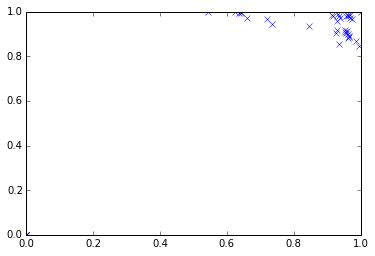

In [42]:
plt.plot(worker_recall_lst,worker_precision_lst,'x')

In [116]:
def getSolutionThreshold(gammas,threshold=0.5):
    if gammas is None:
    	# In the case when the CVX solver can not find a solution, it returns gamma as None and l as inf. 
    	# This happens for Median or Average case, where your T value is just very off, so you can't really find a good ML region corresponding to the T constraints.
    	# This means that our solution set should be empty.
    	return []
    solutionList = []
    for i,gamma in enumerate(gammas):
        if gamma > threshold:
            solutionList.append(i+1)
    return solutionList

In [106]:
gammas = pkl.load(open("gfile{}.pkl".format(objid),'r'))
gamma = gammas[2]

In [107]:
tiles = pkl.load(open("tiles{}.pkl".format(objid),'r'))

In [110]:
tile_areas=[]
for tile in tiles:
    tile_areas.append(Polygon(tile).area)

In [112]:
# tile_areas

potentially sort using tile areas information too

majority vote should be one curve too

In [167]:
def getSolutionTopK(data,k=5):
    return argsort(data)[::-1][:k]

In [177]:
def compute_PR_obj(objid,experiment_idx,threshold=-1,topk=-1,majority_topk=-1):
    '''
    0 = Avrg 
    1 = Median
    2 = Local Search
    3 = Exhaustive Search
    '''
    my_BBG  = pd.read_csv("../../my_ground_truth.csv")
    precision_lst = []
    recall_lst = []
    try:
        tiles = pkl.load(open("tiles{}.pkl".format(objid),'r'))
        gammas = pkl.load(open("gfile{}.pkl".format(objid),'r'))#ga,gm,gl,ge
        # Deriving new solution set from different thresholding criteria
        if majority_topk==-1:
            if threshold!=-1:
                solnset = getSolutionThreshold(gammas[experiment_idx],threshold=threshold)
            elif topk!=-1:
                solnset = getSolutionTopK(gammas[experiment_idx],k=topk)
        else:
            os.chdir("..")
            tiles, objIndicatorMat = createObjIndicatorMatrix(objid,sampleNworkers=40,PRINT=False)
            os.chdir("step500_output")
            worker_tile_votes = np.sum(objIndicatorMat,axis=1)[:-1] 
            solnset = getSolutionTopK(worker_tile_votes,k=majority_topk)
        precision,recall = compute_PR(objid,solnset,tiles)
    except(IOError):
        pass
    return precision,recall

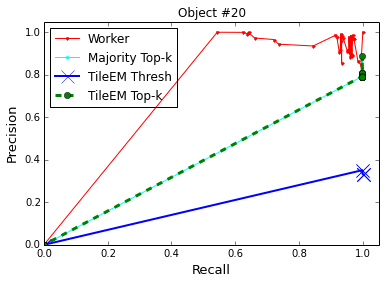

In [181]:
objid = 20
plt.title("Object #{}".format(objid))
# Worker Individual Precision and Recall based on their BB drawn for this object
worker_precision_lst,worker_recall_lst = compute_worker_PR_obj(objid)
order = np.argsort(worker_recall_lst)
plt.plot(worker_recall_lst[order],worker_precision_lst[order], linestyle='-', marker='.',color="red",label="Worker")
# Plotting PR from Top-k Majority vote 
k_lst = np.arange(len(tiles))
Maj_topk_precision_lst = []
Maj_topk_recall_lst = []
for  k in k_lst :
    Maj_topk_precision,Maj_topk_recall= compute_PR_obj(objid,2,topk=k)
    Maj_topk_precision_lst.append(Maj_topk_precision)
    Maj_topk_recall_lst.append(Maj_topk_recall)
Maj_topk_recall_lst = np.array(Maj_topk_recall_lst)
Maj_topk_precision_lst = np.array(Maj_topk_precision_lst)
order = np.argsort(Maj_topk_recall_lst)
plt.plot(Maj_topk_recall_lst[order],Maj_topk_precision_lst[order], linestyle='-', linewidth=1,marker='.',color="cyan",label="Majority Top-k")

# Plotting PR from TileEM for different thresholds
threshold_lst = np.linspace(0,0.95,20)
TileEM_thres_precision_lst = []
TileEM_thres_recall_lst = []
for threshold in threshold_lst :
    TileEM_thres_precision, TileEM_thres_recall= compute_PR_obj(objid,2,threshold=threshold)
    TileEM_thres_precision_lst.append(TileEM_thres_precision)
    TileEM_thres_recall_lst.append(TileEM_thres_recall)
TileEM_thres_recall_lst = np.array(TileEM_thres_recall_lst)
TileEM_thres_precision_lst = np.array(TileEM_thres_precision_lst)
#     print "{0}:{1},{2}".format(threshold,TileEM_thres_precision,TileEM_thres_recall)
order = np.argsort(TileEM_thres_recall_lst)
plt.plot(TileEM_thres_recall_lst[order],TileEM_thres_precision_lst[order], linestyle='-',linewidth=2,ms=13, marker='x',color="blue",label="TileEM Thresh")
# Plotting PR from TileEM for different Top-k
TileEM_topk_precision_lst = []
TileEM_topk_recall_lst = []
for  k in k_lst :
    TileEM_topk_precision, TileEM_topk_recall= compute_PR_obj(objid,2,topk=k)
    TileEM_topk_precision_lst.append(TileEM_topk_precision)
    TileEM_topk_recall_lst.append(TileEM_topk_recall)
TileEM_topk_recall_lst = np.array(TileEM_topk_recall_lst)
TileEM_topk_precision_lst = np.array(TileEM_topk_precision_lst)
order = np.argsort(TileEM_topk_recall_lst)
plt.plot(TileEM_topk_recall_lst[order],TileEM_topk_precision_lst[order], linestyle='--', linewidth=3,marker='o',color="green",label="TileEM Top-k")

plt.xlim(0,1.05)
plt.ylim(0,1.05)
plt.ylabel("Precision",fontsize=13)
plt.xlabel("Recall",fontsize=13)
plt.legend(loc="top left",numpoints=1)

In [1]:
def plot_all_PR_curves(objid):
    plt.figure()
    plt.title("Object #{}".format(objid))
    # Worker Individual Precision and Recall based on their BB drawn for this object
    worker_precision_lst,worker_recall_lst = compute_worker_PR_obj(objid)
    plt.plot(worker_recall_lst ,worker_precision_lst , '.',color="red",label="Worker")
    # Plotting PR from Top-k Majority vote 
    k_lst = np.arange(1,len(tiles))
    Maj_topk_precision_lst = []
    Maj_topk_recall_lst = []
    for  k in k_lst :
        Maj_topk_precision,Maj_topk_recall= compute_PR_obj(objid,2,topk=k)
        Maj_topk_precision_lst.append(Maj_topk_precision)
        Maj_topk_recall_lst.append(Maj_topk_recall)
    Maj_topk_recall_lst = np.array(Maj_topk_recall_lst)
    Maj_topk_precision_lst = np.array(Maj_topk_precision_lst)
    order = np.argsort(Maj_topk_recall_lst)
    plt.plot(Maj_topk_recall_lst[order],Maj_topk_precision_lst[order], linestyle='-', linewidth=1,marker='D',color="cyan",label="Majority Top-k")

    # Plotting PR from TileEM for different thresholds
    threshold_lst = np.linspace(0,0.95,20)
    TileEM_thres_precision_lst = []
    TileEM_thres_recall_lst = []
    for threshold in threshold_lst :
        TileEM_thres_precision, TileEM_thres_recall= compute_PR_obj(objid,2,threshold=threshold)
        TileEM_thres_precision_lst.append(TileEM_thres_precision)
        TileEM_thres_recall_lst.append(TileEM_thres_recall)
    TileEM_thres_recall_lst = np.array(TileEM_thres_recall_lst)
    TileEM_thres_precision_lst = np.array(TileEM_thres_precision_lst)
    #     print "{0}:{1},{2}".format(threshold,TileEM_thres_precision,TileEM_thres_recall)
    order = np.argsort(TileEM_thres_recall_lst)
    plt.plot(TileEM_thres_recall_lst[order],TileEM_thres_precision_lst[order], linestyle='-',linewidth=2,ms=13, marker='x',color="blue",label="TileEM Thresh")
    # Plotting PR from TileEM for different Top-k
    TileEM_topk_precision_lst = []
    TileEM_topk_recall_lst = []
    for  k in k_lst :
        TileEM_topk_precision, TileEM_topk_recall= compute_PR_obj(objid,2,topk=k)
        TileEM_topk_precision_lst.append(TileEM_topk_precision)
        TileEM_topk_recall_lst.append(TileEM_topk_recall)
    TileEM_topk_recall_lst = np.array(TileEM_topk_recall_lst)
    TileEM_topk_precision_lst = np.array(TileEM_topk_precision_lst)
    order = np.argsort(TileEM_topk_recall_lst)
    plt.plot(TileEM_topk_recall_lst[order],TileEM_topk_precision_lst[order], linestyle='--', linewidth=3,marker='o',color="green",label="TileEM Top-k")

    plt.xlim(0,1.05)
    plt.ylim(0,1.05)
    plt.ylabel("Precision",fontsize=13)
    plt.xlabel("Recall",fontsize=13)
    plt.legend(loc="top left",numpoints=1)
    plt.savefig("PR_obj{}.pdf".format(objid))

In [ ]:
def plot_joined_PR_curves(objid):
    # Worker Individual Precision and Recall based on their BB drawn for this object
    worker_precision_lst,worker_recall_lst = compute_worker_PR_obj(objid)
    # Plotting PR from Top-k Majority vote 
    tiles, objIndicatorMat = createObjIndicatorMatrix(objid,sampleNworkers=40,PRINT=False)
    k_lst = np.arange(1,len(tiles))
    Maj_topk_precision_lst = []
    Maj_topk_recall_lst = []
    for  k in k_lst :
        Maj_topk_precision,Maj_topk_recall= compute_PR_obj(objid,2,topk=k)
        Maj_topk_precision_lst.append(Maj_topk_precision)
        Maj_topk_recall_lst.append(Maj_topk_recall)
    Maj_topk_recall_lst = np.array(Maj_topk_recall_lst)
    Maj_topk_precision_lst = np.array(Maj_topk_precision_lst)
    # Plotting PR from TileEM for different thresholds
    threshold_lst = np.linspace(0,0.95,20)
    TileEM_thres_precision_lst = []
    TileEM_thres_recall_lst = []
    for threshold in threshold_lst :
        TileEM_thres_precision, TileEM_thres_recall= compute_PR_obj(objid,2,threshold=threshold)
        TileEM_thres_precision_lst.append(TileEM_thres_precision)
        TileEM_thres_recall_lst.append(TileEM_thres_recall)
    TileEM_thres_recall_lst = np.array(TileEM_thres_recall_lst)
    TileEM_thres_precision_lst = np.array(TileEM_thres_precision_lst)
    # Plotting PR from TileEM for different Top-k
    TileEM_topk_precision_lst = []
    TileEM_topk_recall_lst = []
    for  k in k_lst :
        TileEM_topk_precision, TileEM_topk_recall= compute_PR_obj(objid,2,topk=k)
        TileEM_topk_precision_lst.append(TileEM_topk_precision)
        TileEM_topk_recall_lst.append(TileEM_topk_recall)
    TileEM_topk_recall_lst = np.array(TileEM_topk_recall_lst)
    TileEM_topk_precision_lst = np.array(TileEM_topk_precision_lst)
    return Maj_topk_recall_lst ,Maj_topk_precision_lst,\
            TileEM_thres_recall_lst ,TileEM_thres_precision_lst,\
            TileEM_topk_recall_lst ,TileEM_topk_precision_lst ,\
            worker_recall_lst ,worker_precision_lst 

In [ ]:
Maj_topk_recall_lst =[]
Maj_topk_precision_lst=[]
TileEM_thres_recall_lst =[]
TileEM_thres_precision_lst=[]
TileEM_topk_recall_lst=[]
TileEM_topk_precision_lst =[]
worker_recall_lst =[]
worker_precision_lst=[]
for objid in tqdm(object_lst):   
    Maj_topk_recall, Maj_topk_precision ,TileEM_thres_recall,TileEM_thres_precision, TileEM_topk_recall  ,TileEM_topk_precision ,worker_recall,worker_precision =plot_joined_PR_curves(objid)
    Maj_topk_recall_lst.extend(Maj_topk_recall)
    Maj_topk_precision_lst.extend( Maj_topk_precision)
    TileEM_thres_recall_lst.extend( TileEM_thres_recall)
    TileEM_thres_precision_lst.extend(TileEM_thres_precision)
    TileEM_topk_recall_lst.extend(TileEM_topk_recall)
    TileEM_topk_precision_lst.extend(TileEM_topk_precision)
    worker_recall_lst.extend(worker_recall )
    worker_precision_lst.extend(  worker_precision)

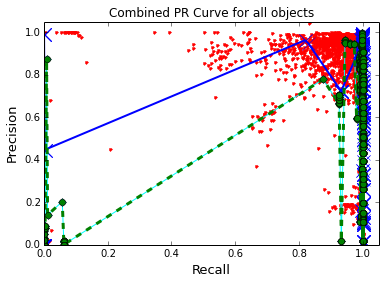

In [229]:
plt.figure()
plt.title("Combined PR Curve for all objects")

plt.plot(worker_recall_lst ,worker_precision_lst , '.',color="red",label="Worker")

Maj_topk_recall_lst = np.array(Maj_topk_recall_lst)
Maj_topk_precision_lst = np.array(Maj_topk_precision_lst)
order = np.argsort(Maj_topk_recall_lst)
plt.plot(Maj_topk_recall_lst[order],Maj_topk_precision_lst[order], linestyle='-', linewidth=1,marker='D',color="cyan",label="Majority Top-k")

TileEM_thres_recall_lst = np.array(TileEM_thres_recall_lst)
TileEM_thres_precision_lst = np.array(TileEM_thres_precision_lst)
order = np.argsort(TileEM_thres_recall_lst)
plt.plot(TileEM_thres_recall_lst[order],TileEM_thres_precision_lst[order], linestyle='-',linewidth=2,ms=13, marker='x',color="blue",label="TileEM Thresh")


TileEM_topk_recall_lst = np.array(TileEM_topk_recall_lst)
TileEM_topk_precision_lst = np.array(TileEM_topk_precision_lst)
order = np.argsort(TileEM_topk_recall_lst)
plt.plot(TileEM_topk_recall_lst[order],TileEM_topk_precision_lst[order], linestyle='--', linewidth=3,marker='o',color="green",label="TileEM Top-k")
plt.xlim(0,1.05)
plt.ylim(0,1.05)
plt.ylabel("Precision",fontsize=13)
plt.xlabel("Recall",fontsize=13)
plt.savefig("PR_obj_all.pdf")

Individual PR Curves

 55%|█████▌    | 26/47 [02:26<01:58,  0.18it/s]ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 49.100000000000001 617.05566218809986 at 49.100000000000001 617.05566218809986
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 49.100000000000001 617.05566218809986 at 49.100000000000001 617.05566218809986
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 49.100000000000001 617.05566218809986 at 49.100000000000001 617.05566218809986
ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 49.100000000000001 617.05566218809986 at 49.100000000000001 617.05566218809986
ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 49.100000000000001 617.05566218809986 at 49.100000000000001 617.05566218809986
ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-

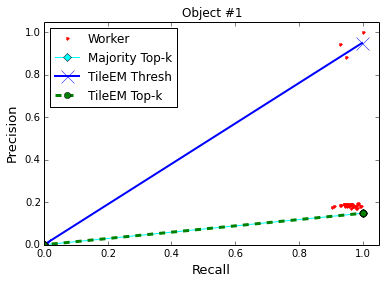

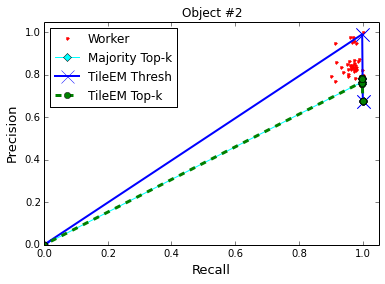

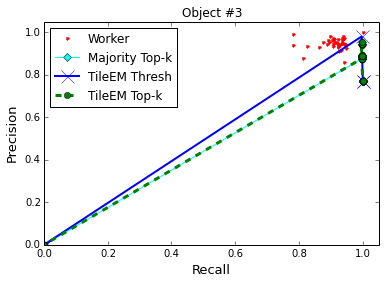

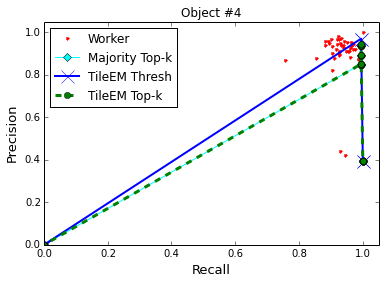

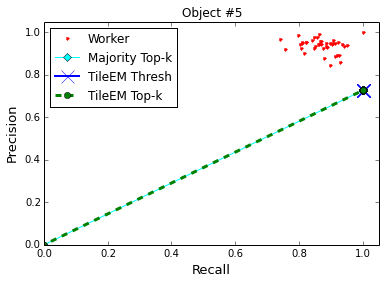

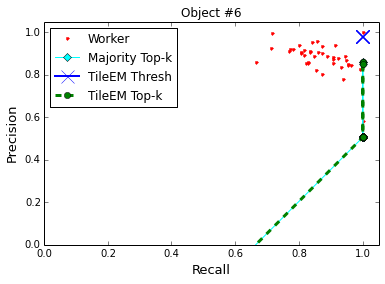

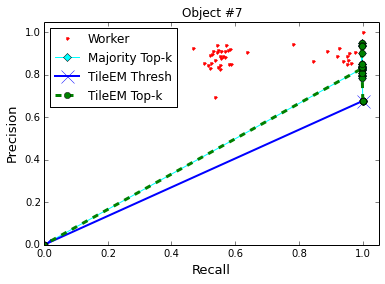

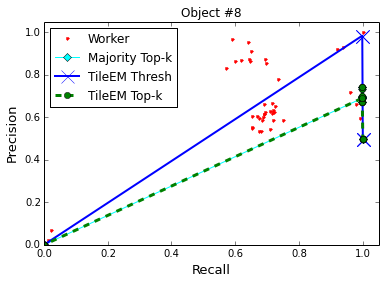

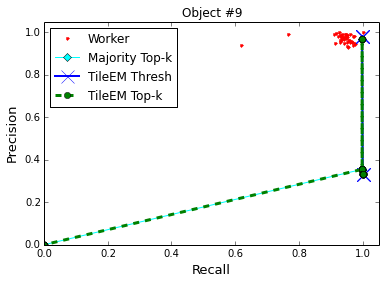

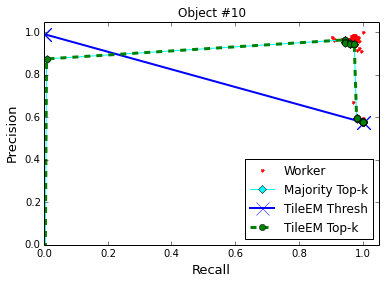

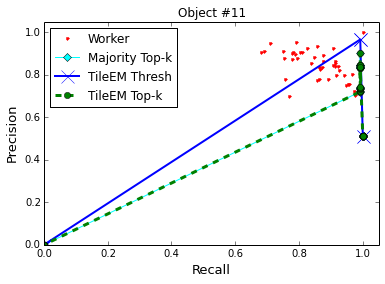

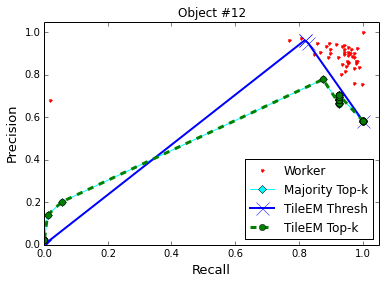

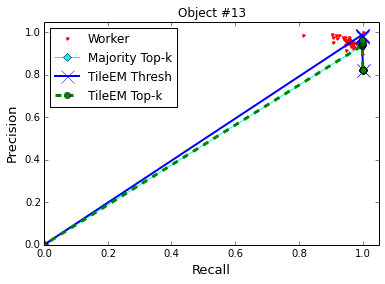

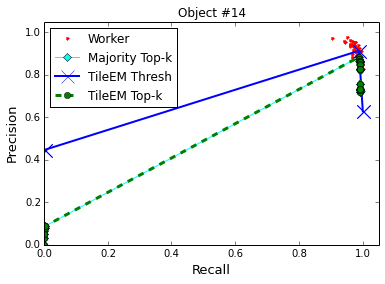

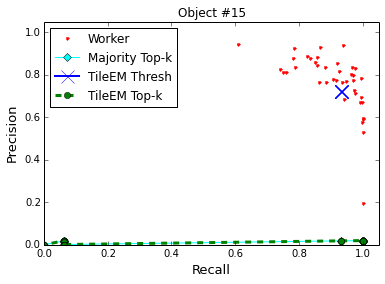

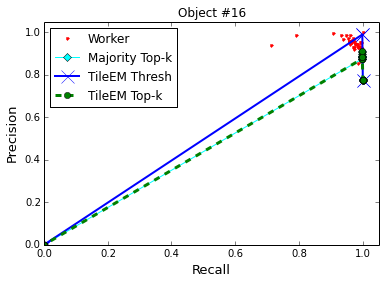

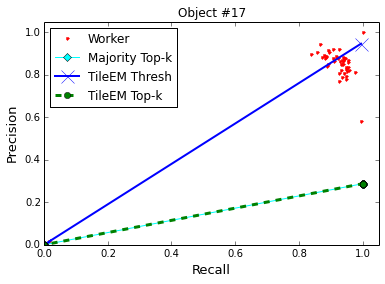

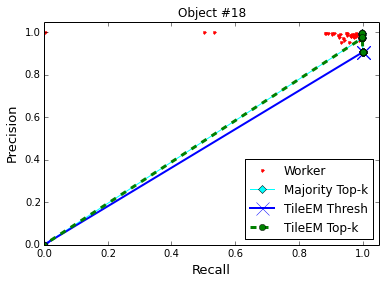

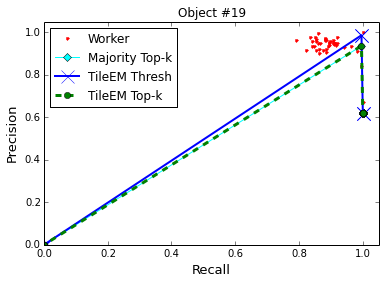

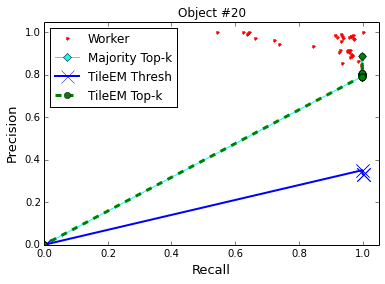

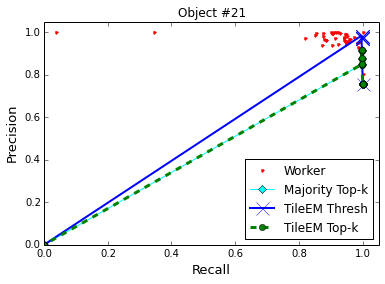

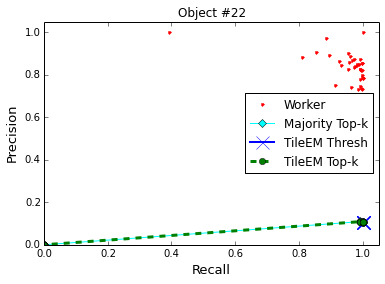

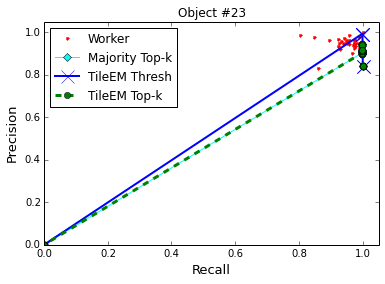

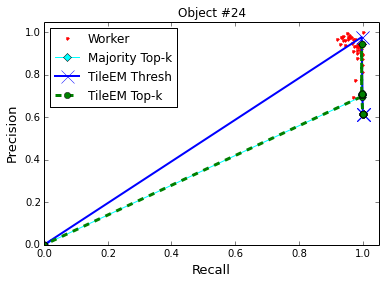

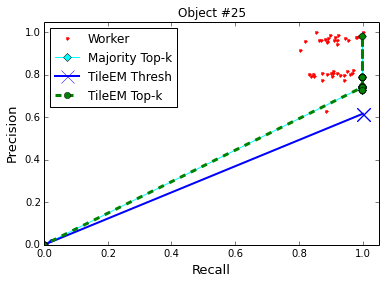

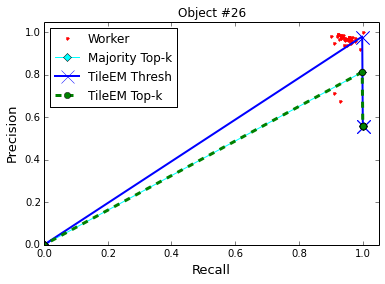

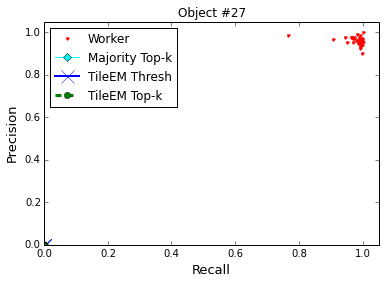

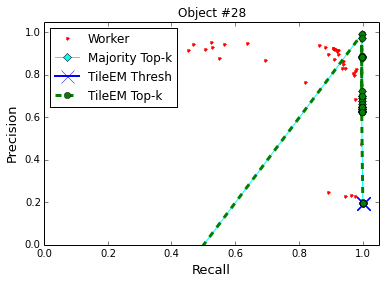

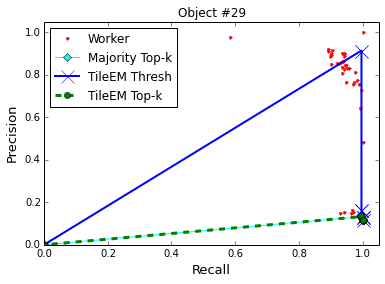

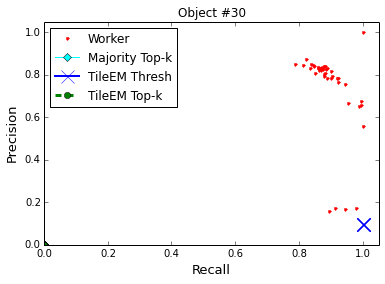

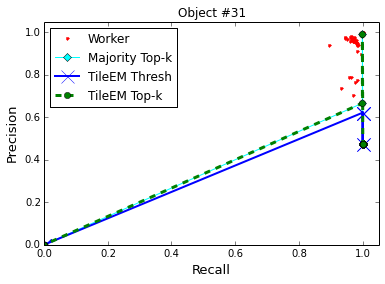

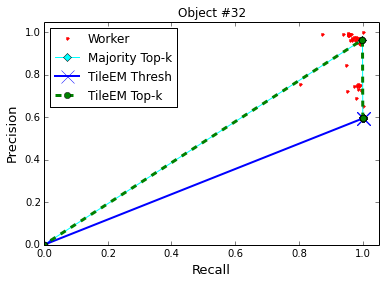

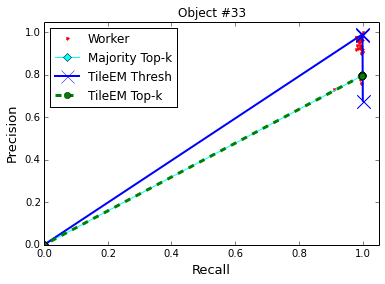

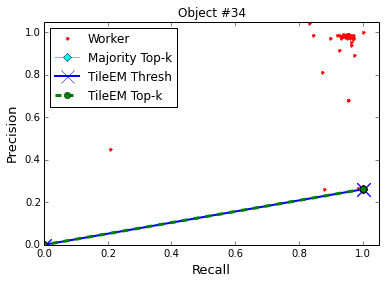

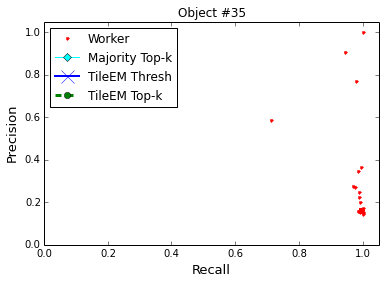

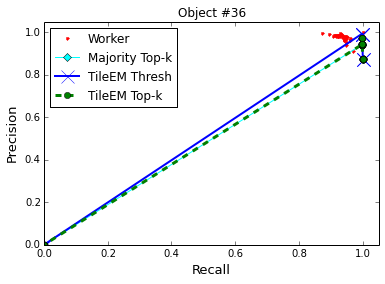

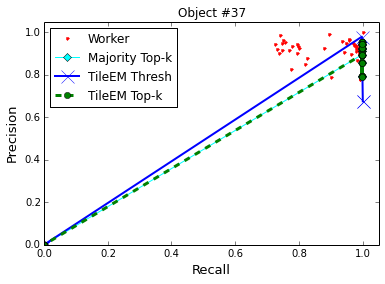

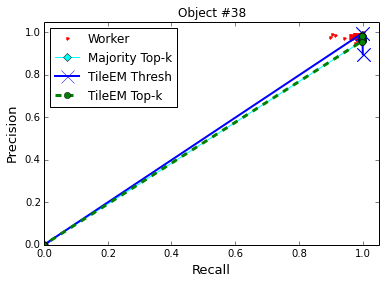

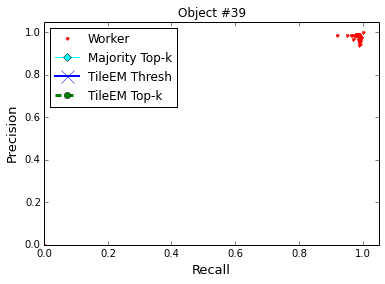

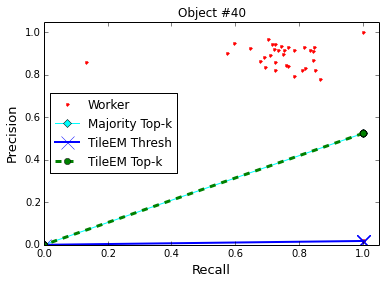

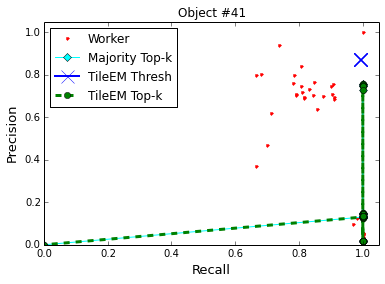

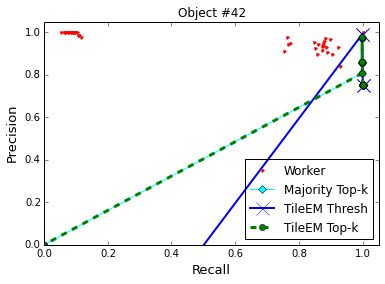

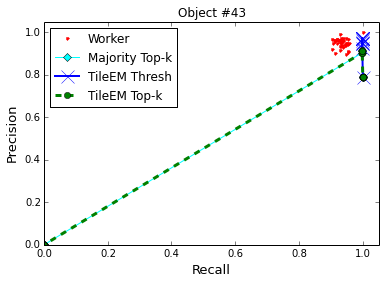

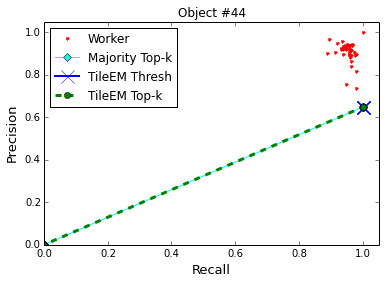

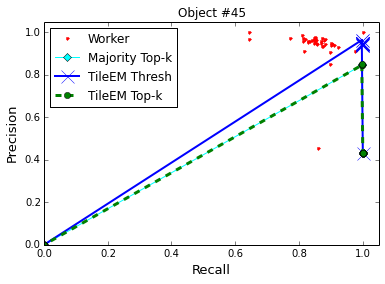

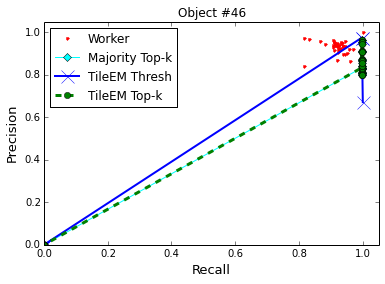

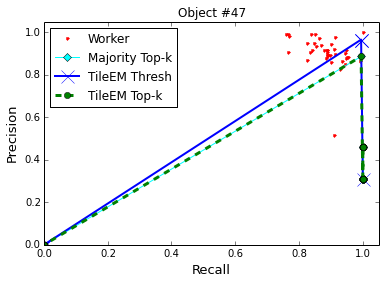

In [226]:
for objid in tqdm(object_lst):
    plot_all_PR_curves(objid)

------------------------------------------------------------------------------------------------------------------------------------------------

In [140]:
def compute_all_PR(idx):
    '''
    0 = Avrg 
    1 = Median
    2 = Local Search
    3 = Exhaustive Search
    '''
    my_BBG  = pd.read_csv("../../my_ground_truth.csv")
    object_lst = list(object_tbl.id)
    precision_lst = []
    recall_lst = []
    for objid in object_lst:
        try:
            tiles = pkl.load(open("tiles{}.pkl".format(objid),'r'))
            solnsets = pkl.load(open("solnfile{}.pkl".format(objid),'r'))#solutionLista,solutionListm,solutionListl,solutionListe
            gammas = pkl.load(open("gfile{}.pkl".format(objid),'r'))#ga,gm,gl,ge
            recall,precision = compute_PR(objid,solnsets[idx],tiles)
            precision_lst.append(precision)
            recall_lst.append(recall)
        except(IOError):
            pass
    return precision_lst,recall_lst
    

ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 151.44069993519119 467.10000000000002 at 151.44069993519119 467.10000000000002


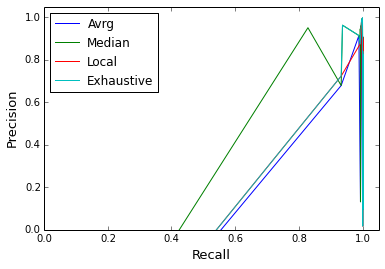

In [142]:
experiment_names = {0:'Avrg',1:'Median',2:'Local',3:'Exhaustive'}
for experiment_idx in range(4):
    plst,rlst = compute_all_PR(experiment_idx)
    order = np.argsort(rlst)
    x = np.array(rlst)[order]
    y = np.array(plst)[order]
    plt.plot(x,y,'-',label=experiment_names[experiment_idx])
plt.xlim(0,1.05)
plt.ylim(0,1.05)
plt.ylabel("Precision",fontsize=13)
plt.xlabel("Recall",fontsize=13)
plt.legend(loc="top left",numpoints=1)

### Given gamma values, recompute solution sets with a different threshold

In [126]:
objid=13 
gammas = pkl.load(open("gfile{}.pkl".format(objid),'r'))#ga,gm,gl,ge

In [173]:
# Deriving new solution set from different thresholding criteria
solnsets = []
for experiment_idx in range(shape(gammas)[0]):
    solnsets.append(getSolutionThreshold(gammas[experiment_idx],threshold=0.5))

In [174]:
solnsets

[[35, 37, 38, 40, 43, 1, 39, 41, 45],
 [37, 38, 43, 39, 40, 41],
 [35, 36, 37, 38, 40, 43, 1, 39, 41, 42, 44, 45],
 [37, 38, 40, 43, 1, 35, 39, 41, 45]]

In [293]:
print plst

[0.0, 0.0, 0.0, 0.0, 0.0, -1, 0.0, 0.0, 0.0, 0.9912067099567093, 0.0, 0.0, 0.0, 0.6360213000678889, 0.7229343057799851, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9621294119396593, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19876092032453238, 0.0, 0.09686829197044172, 0.0, 0.0, 0.0, 0.0, -1, 0.0, 0.0, 0.0, -1, 0.017984539348164904, 0.8744791684642906, -1, 0.0, 0.0, 0.0, 0.0, 0.0]


ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 151.44069993519119 467.10000000000002 at 151.44069993519119 467.10000000000002


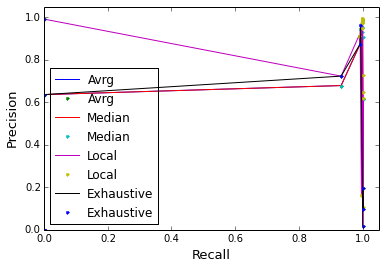

In [294]:
experiment_names = {0:'Avrg',1:'Median',2:'Local',3:'Exhaustive'}
for experiment_idx in range(4):
    plst,rlst = compute_all_PR_threshold(experiment_idx,threshold=0.5)
    order = np.argsort(rlst)
    x = np.array(rlst)[order]
    y = np.array(plst)[order]
    plt.plot(x,y,'-',label=experiment_names[experiment_idx])
    plt.plot(x,y,'.',label=experiment_names[experiment_idx])
plt.xlim(0,1.05)
plt.ylim(0,1.05)
plt.ylabel("Precision",fontsize=13)
plt.xlabel("Recall",fontsize=13)
plt.legend(loc="top left",numpoints=1)

#### Drawing Precision and Recall Curves separately, x axis is worker or sth

In [254]:
def plotPRCurves(threshold):
    f, axarr = plt.subplots(2, sharex=True)

    experiment_names = {0:'Avrg',1:'Median',2:'Local',3:'Exhaustive'}
    for experiment_idx in range(4):
        plst,rlst = compute_all_PR_threshold(experiment_idx,threshold= threshold)
        axarr[0].plot(np.array(plst)[np.argsort(plst)],'-',label=experiment_names[experiment_idx])
        axarr[1].plot(np.array(rlst)[np.argsort(rlst)],'-',label=experiment_names[experiment_idx])

    axarr[0].set_title("Precision",fontsize=12)
    axarr[1].set_title("Recall",fontsize=12)

    axarr[0].set_ylim(0,1.05)
    axarr[1].set_ylim(0,1.05)
    axarr[0].legend(loc="top left",numpoints=1)
    plt.suptitle("Gamma>{}".format(threshold),fontsize=13,position=(0.51,1))

ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 151.44069993519119 467.10000000000002 at 151.44069993519119 467.10000000000002


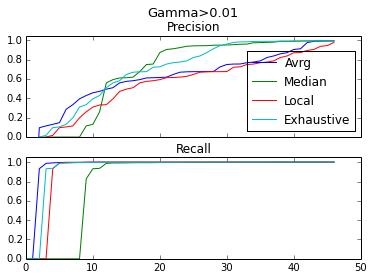

In [255]:
plotPRCurves(0.01)

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 151.44069993519119 467.10000000000002 at 151.44069993519119 467.10000000000002


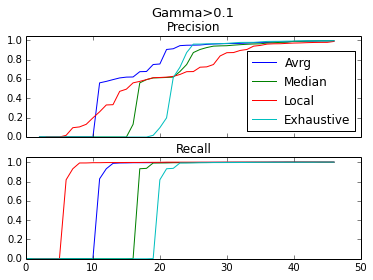

In [256]:
plotPRCurves(0.1)

ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 151.44069993519119 467.10000000000002 at 151.44069993519119 467.10000000000002


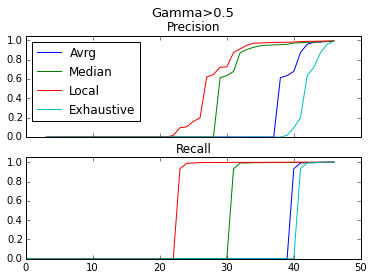

In [257]:
plotPRCurves(0.5)

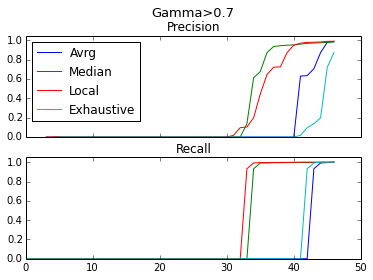

In [258]:
plotPRCurves(0.7)

In [286]:
def plotPRCurvesVaryGamma(threshold_lst,experiment_idx=2):
    f, axarr = plt.subplots(2, sharex=True)

    experiment_names = {0:'Avrg',1:'Median',2:'Local',3:'Exhaustive'}
    color=iter(cm.cool(np.linspace(0,1,len(threshold_lst))))

    for threshold in threshold_lst:
        c=next(color)
        plst,rlst = compute_all_PR_threshold(experiment_idx,threshold= threshold)
        axarr[0].plot(np.array(plst)[np.argsort(plst)],'-',label="Gamma > {}".format(threshold),c=c)
        axarr[1].plot(np.array(rlst)[np.argsort(rlst)],'-',label="Gamma > {}".format(threshold),c=c)

    axarr[0].set_title("Precision",fontsize=12)
    axarr[1].set_title("Recall",fontsize=12)

    axarr[0].set_ylim(0,1.05)
    axarr[1].set_ylim(0,1.05)
    
    lgd = axarr[0].legend( loc="center right",numpoints=1, bbox_to_anchor=(1.5, -0.1))
    plt.suptitle(experiment_names[experiment_idx],fontsize=13,position=(0.51,1))
    
    f.savefig('PRVaryGamma.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 151.44069993519119 467.10000000000002 at 151.44069993519119 467.10000000000002
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 151.44069993519119 467.10000000000002 at 151.44069993519119 467.10000000000002
ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 151.44069993519119 467.10000000000002 at 151.44069993519119 467.10000000000002
ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 151.44069993519119 467.10000000000002 at 151.44069993519119 467.10000000000002
ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 151.44069993519119 467.10000000000002 at 151.44069993519119 467.10000000000002
ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 151.4406999351911

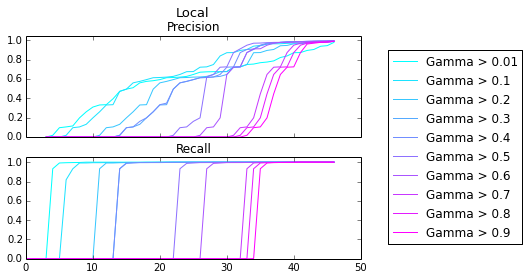

In [287]:
plotPRCurvesVaryGamma([0.01,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])